In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import io

# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))

# Read the Excel file
excel_file = pd.ExcelFile(io.BytesIO(uploaded[file_name]))

# Read the data from the Excel file
data = pd.read_excel(excel_file, header=0, index_col=0)

Saving 1_Average_strain_top_twist1_nRMSE.xlsx to 1_Average_strain_top_twist1_nRMSE.xlsx


In [2]:
# Transpose the data so that each row represents a configuration
X = data.T

# Rename columns to represent strain gauges
X.columns = [f'SG{i+1}' for i in np.arange(X.shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X = X.dropna()

combined_data = X

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
np.shape(X_scaled)

(3435, 26)

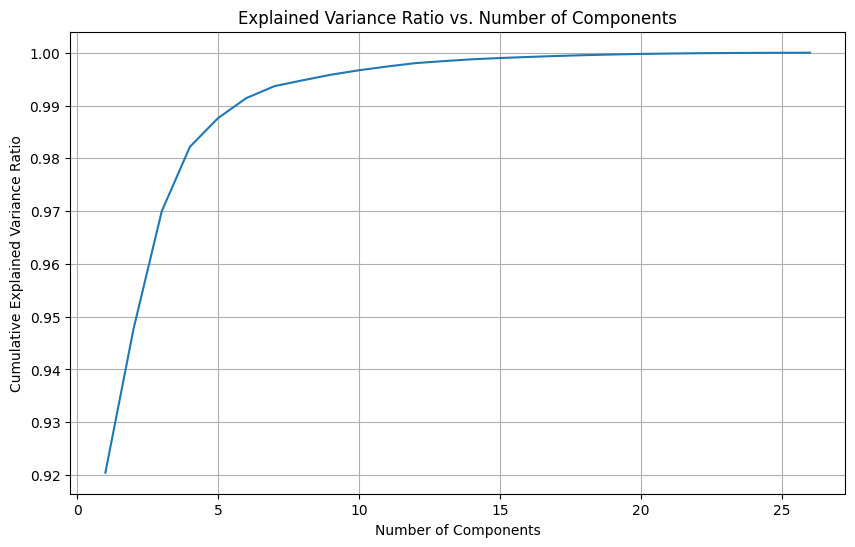

Measurement Point Importance:
           PC1       PC2       PC3       PC4       PC5       PC6
SG17  0.203765  0.012121  0.031470  0.044837  0.023414  0.068236
SG23  0.203722  0.011893  0.038932  0.047679  0.028300  0.058047
SG10  0.203605  0.009868  0.034941  0.034172  0.004447  0.105612
SG4   0.203482  0.001716  0.032593  0.119534  0.002446  0.033835
SG11  0.203228  0.032583  0.074764  0.124042  0.022379  0.002880
SG12  0.203227  0.002782  0.043449  0.081044  0.086312  0.021926
SG18  0.202769  0.079551  0.059063  0.135766  0.077931  0.056826
SG1   0.202675  0.016790  0.085095  0.000661  0.200612  0.175131
SG25  0.202353  0.020482  0.077989  0.116658  0.028772  0.060177
SG21  0.202342  0.023845  0.068820  0.005627  0.215207  0.188036
SG2   0.201862  0.006653  0.028988  0.129594  0.048889  0.038042
SG6   0.201751  0.003226  0.049317  0.027771  0.251350  0.112330
SG19  0.201668  0.046342  0.086743  0.080927  0.105206  0.073412
SG15  0.201579  0.051659  0.070009  0.110293  0.005926  0.13

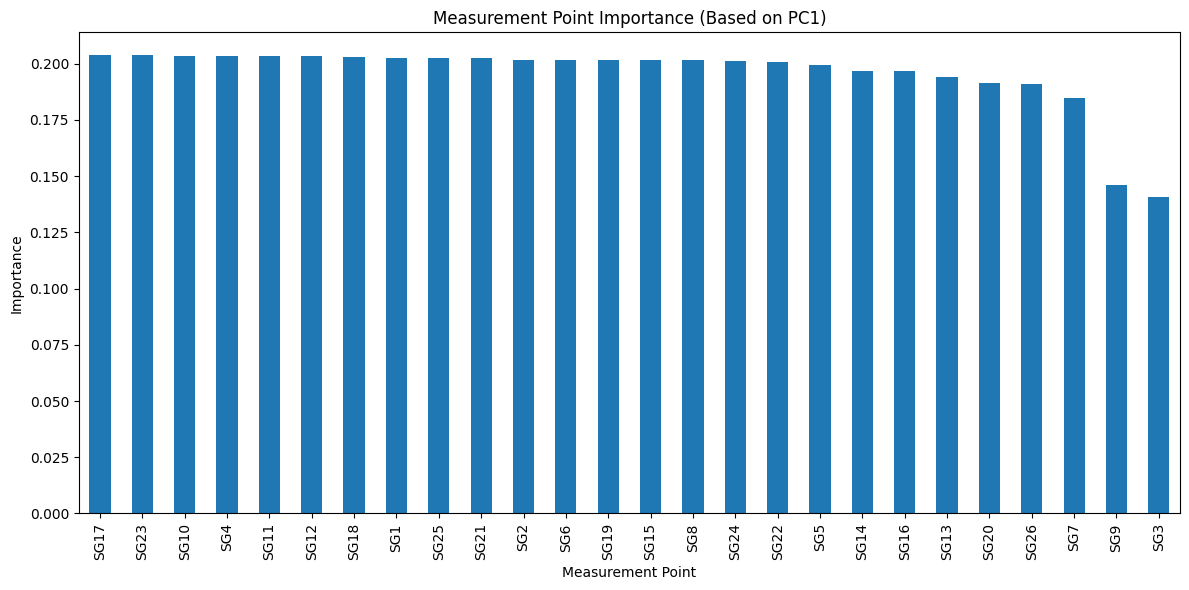

In [6]:
# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Analyzing Strain Gauge Importance
# Get the absolute values of the first few principal components
component_importance = np.abs(pca.components_[:6])  # Adjust the number of components as needed

# Create a DataFrame to store the importance of each measurement point
sg_importance = pd.DataFrame(
    component_importance.T,
    columns=[f'PC{i+1}' for i in np.arange(component_importance.shape[0])],
    index=[f'SG{i+1}' for i in np.arange(X.shape[1])]
)

# Sort measurement points by their importance in the first principal component
sg_importance_sorted = sg_importance.sort_values('PC1', ascending=False)

print("Measurement Point Importance:")
print(sg_importance_sorted)

# Visualize the importance of measurement points
plt.figure(figsize=(12, 6))
sg_importance_sorted['PC1'].plot(kind='bar')
plt.title('Measurement Point Importance (Based on PC1)')
plt.xlabel('Measurement Point')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [7]:
print("\n".join(f"{i}\t{var}" for i, var in zip(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)))


1	0.9204330063692437
2	0.9477050284281996
3	0.969961596006146
4	0.9821848177468852
5	0.9876238152038285
6	0.9914004870985066
7	0.9936684237333584
8	0.9947744993240734
9	0.9958311032100129
10	0.9966791123951865
11	0.9973894766903365
12	0.9980285285837341
13	0.998405711614588
14	0.9987543514961261
15	0.9989930591315119
16	0.9991972516600568
17	0.9993807761471363
18	0.9995409523312783
19	0.9996644781830788
20	0.9997709672977843
21	0.9998424869078163
22	0.999906230233003
23	0.9999429483764061
24	0.9999691998318163
25	0.9999921468113411
26	0.9999999999999999


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Removing Redundant Measurement Points
# Set a threshold for cumulative explained variance
threshold = 0.99
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

print(f"Number of components needed to explain {threshold*100}% of variance: {n_components}")

# Get the loadings for the retained components
loadings = pd.DataFrame(
    pca.components_[:n_components].T,
    columns=[f'PC{i+1}' for i in np.arange(n_components)],
    index=[f'SG{i+1}' for i in np.arange(X.shape[1])]
)

# Calculate the maximum absolute loading for each measurement point
max_loadings = loadings.abs().max(axis=1)

# Sort measurement points by their maximum loading
sorted_sg = max_loadings.sort_values(ascending=False)

print("\nMeasurement points sorted by importance:")
print(sorted_sg)

# Select the top N important strain gauges, where N is the number of components
important_sgs = sorted_sg.head(n_components).index.tolist()

print("\nImportant strain gauges:")
print(important_sgs)

# Calculate the cumulative importance of the selected strain gauges
selected_importance = sorted_sg.head(n_components).sum() / sorted_sg.sum()
print(f"\nCumulative importance of selected strain gauges: {selected_importance:.4f}")

Number of components needed to explain 99.0% of variance: 6

Measurement points sorted by importance:
SG3     0.932604
SG9     0.709353
SG7     0.648042
SG14    0.489943
SG20    0.357739
SG26    0.350223
SG13    0.308093
SG8     0.283694
SG16    0.281450
SG6     0.251350
SG5     0.223260
SG21    0.215207
SG17    0.203765
SG23    0.203722
SG10    0.203605
SG4     0.203482
SG11    0.203228
SG12    0.203227
SG18    0.202769
SG1     0.202675
SG25    0.202353
SG2     0.201862
SG19    0.201668
SG15    0.201579
SG24    0.201075
SG22    0.200887
dtype: float64

Important strain gauges:
['SG3', 'SG9', 'SG7', 'SG14', 'SG20', 'SG26']

Cumulative importance of selected strain gauges: 0.4422


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import io

# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))

# Read the Excel file
excel_file = pd.ExcelFile(io.BytesIO(uploaded[file_name]))

# Read the data from the Excel file
data = pd.read_excel(excel_file, header=0, index_col=0)

# Transpose the data so that each row represents a configuration
X = data.T

# Rename columns to represent strain gauges
X.columns = [f'SG{i+1}' for i in np.arange(X.shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X = X.dropna()

combined_data = X

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
np.shape(X_scaled)

Saving 2_Smoothed_Twist1Strains_From_DIC_9cycles.xlsx to 2_Smoothed_Twist1Strains_From_DIC_9cycles.xlsx


(3300, 26)

In [ ]:
# Prepare input (X) and target (y) data
X = combined_data[important_sgs]
y = combined_data.drop(columns=important_sgs)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Create PyTorch datasets
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StrainDataset(X_train_scaled, y_train_scaled)
test_dataset = StrainDataset(X_test_scaled, y_test_scaled)

In [ ]:
print(np.shape(X))
print(np.shape(y))

(3300, 6)
(3300, 20)


Epoch [1/50], Train Loss: 0.2659, Test Loss: 0.0167
Epoch [2/50], Train Loss: 0.0145, Test Loss: 0.0143
Epoch [3/50], Train Loss: 0.0129, Test Loss: 0.0123
Epoch [4/50], Train Loss: 0.0111, Test Loss: 0.0105
Epoch [5/50], Train Loss: 0.0096, Test Loss: 0.0093
Epoch [6/50], Train Loss: 0.0085, Test Loss: 0.0081
Epoch [7/50], Train Loss: 0.0078, Test Loss: 0.0074
Epoch [8/50], Train Loss: 0.0073, Test Loss: 0.0076
Epoch [9/50], Train Loss: 0.0068, Test Loss: 0.0070
Epoch [10/50], Train Loss: 0.0066, Test Loss: 0.0066
Epoch [11/50], Train Loss: 0.0065, Test Loss: 0.0067
Epoch [12/50], Train Loss: 0.0063, Test Loss: 0.0063
Epoch [13/50], Train Loss: 0.0062, Test Loss: 0.0062
Epoch [14/50], Train Loss: 0.0060, Test Loss: 0.0059
Epoch [15/50], Train Loss: 0.0058, Test Loss: 0.0058
Epoch [16/50], Train Loss: 0.0058, Test Loss: 0.0059
Epoch [17/50], Train Loss: 0.0057, Test Loss: 0.0060
Epoch [18/50], Train Loss: 0.0055, Test Loss: 0.0056
Epoch [19/50], Train Loss: 0.0054, Test Loss: 0.0055
Ep

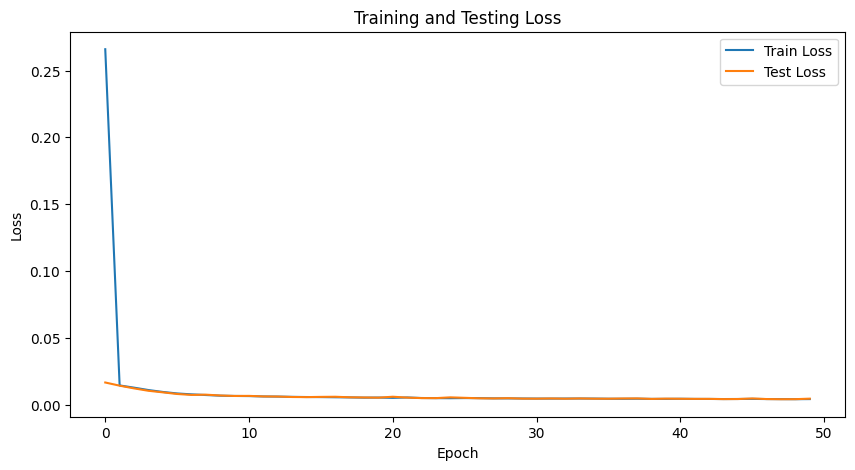

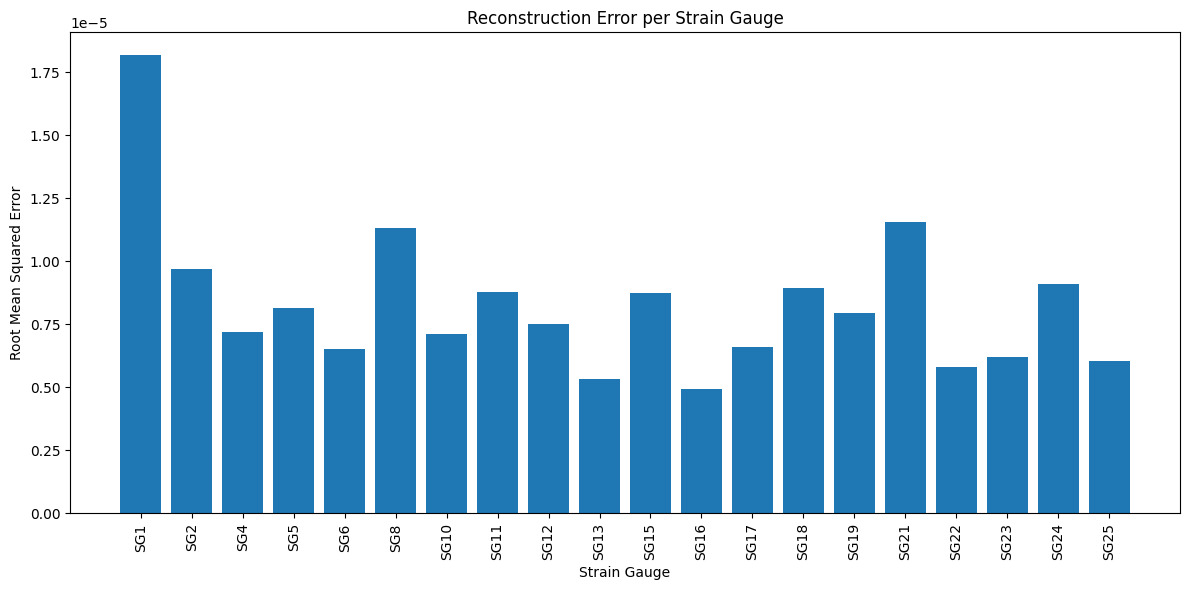

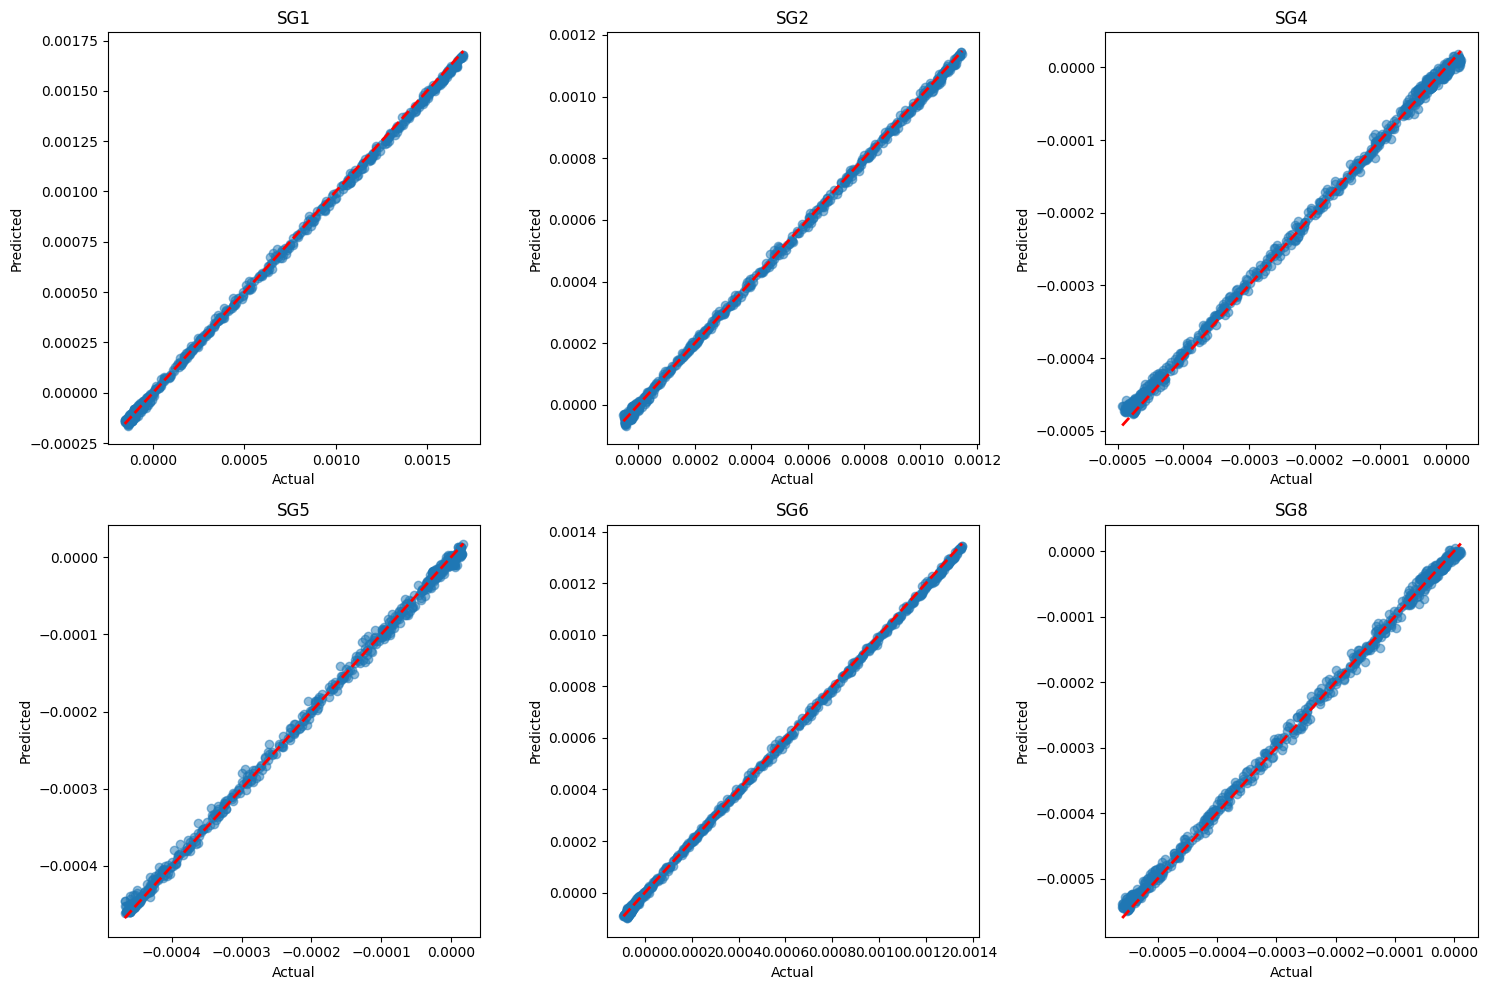

Model training and evaluation complete.


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class StrainFieldReconstructor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StrainFieldReconstructor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = StrainFieldReconstructor(input_size=len(important_sgs), hidden_size=64, output_size=y.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in np.arange(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Evaluate the model on the test set
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        actuals.append(targets.numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the predictions and actuals
predictions_original = scaler_y.inverse_transform(predictions)
actuals_original = scaler_y.inverse_transform(actuals)

# Calculate MSE for each strain gauge
mse_per_sg = np.mean((predictions_original - actuals_original)**2, axis=0)

rmse_per_sg = np.sqrt(np.mean((predictions_original - actuals_original)**2, axis=0))

# Create a list of strain gauge names for the MSE values
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]

# Plot MSE for each predicted strain gauge
plt.figure(figsize=(12, 6))
plt.bar(output_sgs, rmse_per_sg)
plt.xlabel('Strain Gauge')
plt.ylabel('Root Mean Squared Error')
plt.title('Reconstruction Error per Strain Gauge')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize actual vs predicted for a few strain gauges, excluding important ones
output_sgs = [sg for sg in combined_data.columns if sg not in important_sgs]

num_plots = min(6, len(output_sgs))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in np.arange(num_plots):
    sg = output_sgs[i]
    sg_index = combined_data.columns.get_loc(sg)
    axes[i].scatter(actuals_original[:, sg_index], predictions_original[:, sg_index], alpha=0.5)
    axes[i].plot([actuals_original[:, sg_index].min(), actuals_original[:, sg_index].max()],
                 [actuals_original[:, sg_index].min(), actuals_original[:, sg_index].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(sg)

# Remove any unused subplots
for i in np.arange(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


print("Model training and evaluation complete.")
torch.save(model.state_dict(), '1_Arduino_Bending_TopSurface.pth')



In [ ]:
for sg, mse in zip(output_sgs, rmse_per_sg):
    print(f"{sg}\t{mse}")

SG1	1.817566044337582e-05
SG2	9.715809937915765e-06
SG4	7.202635970315896e-06
SG5	8.16716692497721e-06
SG6	6.5301287577312905e-06
SG8	1.1308326975267846e-05
SG10	7.111712420737604e-06
SG11	8.788319973973557e-06
SG12	7.516123332607094e-06
SG13	5.321663138602162e-06
SG15	8.758577678236179e-06
SG16	4.93187690153718e-06
SG17	6.598336312890751e-06
SG18	8.93340529728448e-06
SG19	7.970554179337341e-06
SG21	1.1577224540815223e-05
SG22	5.819518719363259e-06
SG23	6.211760592123028e-06
SG24	9.088073966267984e-06
SG25	6.032079909346066e-06


In [ ]:
np.shape(predictions_original)

(660, 20)

In [ ]:
# Find SG1's index in output strain gauges
sg1_index = output_sgs.index('SG1')

# Extract and save data
predicted_sg1 = predictions_original[:, sg1_index]
actual_sg1 = actuals_original[:, sg1_index]

np.savetxt('predicted_sg1.txt', predicted_sg1, fmt='%.6f')
np.savetxt('actual_sg1.txt', actual_sg1, fmt='%.6f')

from google.colab import files
files.download('predicted_sg1.txt')
files.download('actual_sg1.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

def calculate_rmse(predictions, actuals):
    return np.sqrt(np.mean((predictions - actuals) ** 2))
rmse = calculate_rmse(predictions_original, actuals_original)
print(f"RMSE: {rmse}")


RMSE: 8.774535672273487e-06


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Print shapes of training and test data
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training output shape: {y_train_scaled.shape}")
print(f"Test output shape: {y_test_scaled.shape}")

# Calculate RMSE for each strain gauge
rmse_per_sg = np.sqrt(mean_squared_error(actuals_original, predictions_original, multioutput='raw_values'))

# Calculate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))

# Create a list of strain gauge names, excluding the important ones
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]


# Print RMSE for each predicted strain gauge
print("\nRMSE for each predicted strain gauge:")
for sg, rmse in zip(output_sgs, rmse_per_sg):
    print(f"{sg}: {rmse:.2e}")

print(f"\nOverall RMSE: {overall_rmse:.2e}")

Training data shape: (2640, 6)
Test data shape: (660, 6)
Training output shape: (2640, 20)
Test output shape: (660, 20)

RMSE for each predicted strain gauge:
SG1: 1.82e-05
SG2: 9.72e-06
SG4: 7.20e-06
SG5: 8.17e-06
SG6: 6.53e-06
SG8: 1.13e-05
SG10: 7.11e-06
SG11: 8.79e-06
SG12: 7.52e-06
SG13: 5.32e-06
SG15: 8.76e-06
SG16: 4.93e-06
SG17: 6.60e-06
SG18: 8.93e-06
SG19: 7.97e-06
SG21: 1.16e-05
SG22: 5.82e-06
SG23: 6.21e-06
SG24: 9.09e-06
SG25: 6.03e-06

Overall RMSE: 8.77e-06


In [ ]:
overall_min_test = X_test.min().min()
overall_max_test = X_test.max().max()
print(f"\nOverall range across all strain gauges in the test set: {overall_min_test:.6f} to {overall_max_test:.6f}")



Overall range across all strain gauges in the test set: -0.000408 to 0.001506


In [ ]:
range = overall_max_test - overall_min_test
rmse_percentage = (overall_rmse / range) * 100
print(f"\nRMSE as percentage of overall test range: {rmse_percentage:.2f}%")



RMSE as percentage of overall test range: 0.46%


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores = []
for i in np.arange(predictions_original.shape[1]):
    r2 = r2_score(actuals_original[:, i], predictions_original[:, i])
    r2_scores.append(r2)

# Calculate the median and range of R2 scores
median_r2 = np.median(r2_scores)
range_r2 = (min(r2_scores), max(r2_scores))

print(f"Median R2 score: {median_r2:.4f}")
print(f"Range of R2 scores: ({range_r2[0]:.4f}, {range_r2[1]:.4f})")


Median R2 score: 0.9982
Range of R2 scores: (0.9482, 0.9995)


In [ ]:
import pandas as pd

# Assuming these variables are already calculated
data = {
    "Metric": [
        "Training data shape",
        "Test data shape",
        "Overall RMSE",
        "Overall range across all strain gauges in the test set",
        "RMSE as percentage of overall test range",
        "Median R2 score",
        "Range of R2 scores"
    ],
    "Value": [
        f"{X_train.shape}",
        f"{X_test.shape}",
        f"{overall_rmse:.6f}",
        f"{overall_min_test:.6f} to {overall_max_test:.6f}",
        f"{rmse_percentage:.2f}%",
        f"{median_r2:.2f}",
        f"({range_r2[0]:.2f}, {range_r2[1]:.2f})"
    ]
}

df = pd.DataFrame(data)

# Print the DataFrame in a tab-separated format
print(df.to_csv(sep='\t', index=False))


Metric	Value
Training data shape	(2640, 6)
Test data shape	(660, 6)
Overall RMSE	0.000009
Overall range across all strain gauges in the test set	-0.000408 to 0.001506
RMSE as percentage of overall test range	0.46%
Median R2 score	1.00
Range of R2 scores	(0.95, 1.00)



In [ ]:
# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name2 = next(iter(uploaded))

# Read the Excel file calculated_pca_sg_strains_validation.xlsx
data2 = pd.read_excel(io.BytesIO(uploaded[file_name2]), header=0, index_col=0)



Saving 3_PCA_sg_strains_plus_nonPCA_DIC_strains_2cycles.xlsx to 3_PCA_sg_strains_plus_nonPCA_DIC_strains_2cycles.xlsx


In [ ]:
# Transpose the data so that each row represents a configuration
X_validation = data2.T

# Rename columns to represent strain gauges
X_validation_columns = [f'SG{i+1}' for i in np.arange(X_validation .shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X_validation  = X_validation .apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X_validation  = X_validation .dropna()

combined_data_val = X_validation.copy()

In [ ]:
print(X_validation.columns)
print(np.shape(X_validation))

Index(['SG3', 'SG9', 'SG7', 'SG14', 'SG20', 'SG26', 'SG1', 'SG2', 'SG4', 'SG5',
       'SG6', 'SG8', 'SG10', 'SG11', 'SG12', 'SG13', 'SG15', 'SG16', 'SG17',
       'SG18', 'SG19', 'SG21', 'SG22', 'SG23', 'SG24', 'SG25'],
      dtype='object', name='StrainGauge')
(366, 26)


In [ ]:

X_validation  = combined_data_val[important_sgs]
y_validation  = combined_data_val.drop(columns=important_sgs)
print(np.shape(X_validation))
print(np.shape(y_validation))

(366, 6)
(366, 20)


In [ ]:
X_validation_scaled = scaler_X.transform(X_validation)

In [ ]:
y_validation_scaled = scaler_y.transform(y_validation)

In [ ]:
validation_dataset = StrainDataset(X_validation_scaled, y_validation_scaled)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
# Evaluate the model on the validation set
model.eval()
predictions_val = []
actuals_val = []
with torch.no_grad():
    for inputs, targets in validation_loader:
        outputs = model(inputs)
        predictions_val.append(outputs.numpy())
        actuals_val.append(targets.numpy())

In [ ]:
predictions_val = np.concatenate(predictions_val)
actuals_val = np.concatenate(actuals_val)

# Inverse transform the predictions and actuals
predictions_original_val = scaler_y.inverse_transform(predictions_val)
actuals_original_val = scaler_y.inverse_transform(actuals_val)

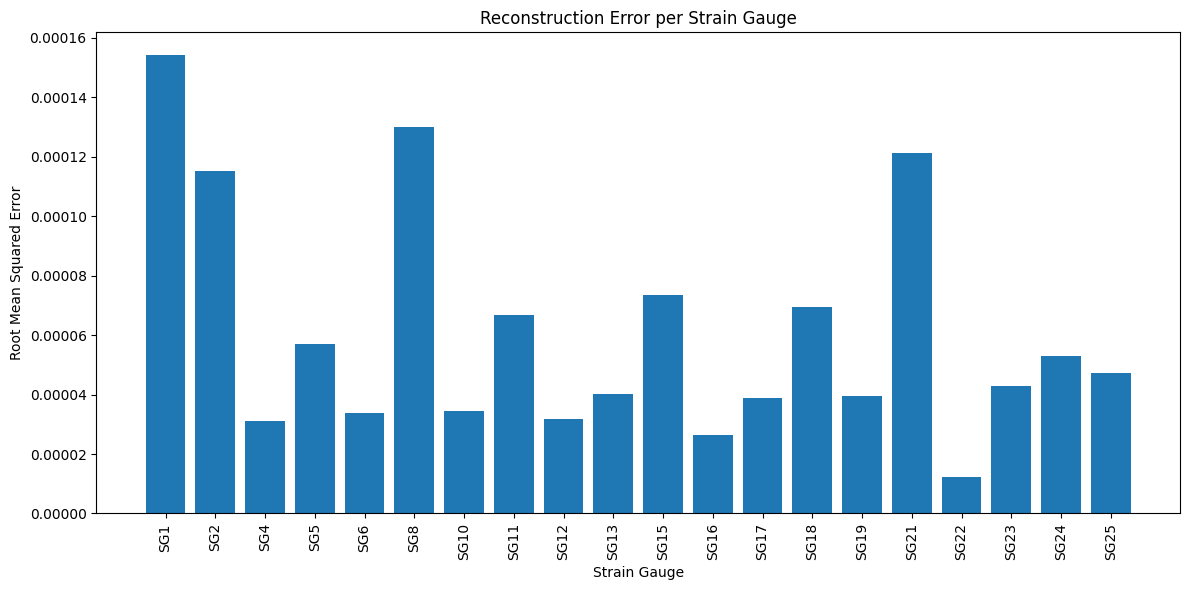

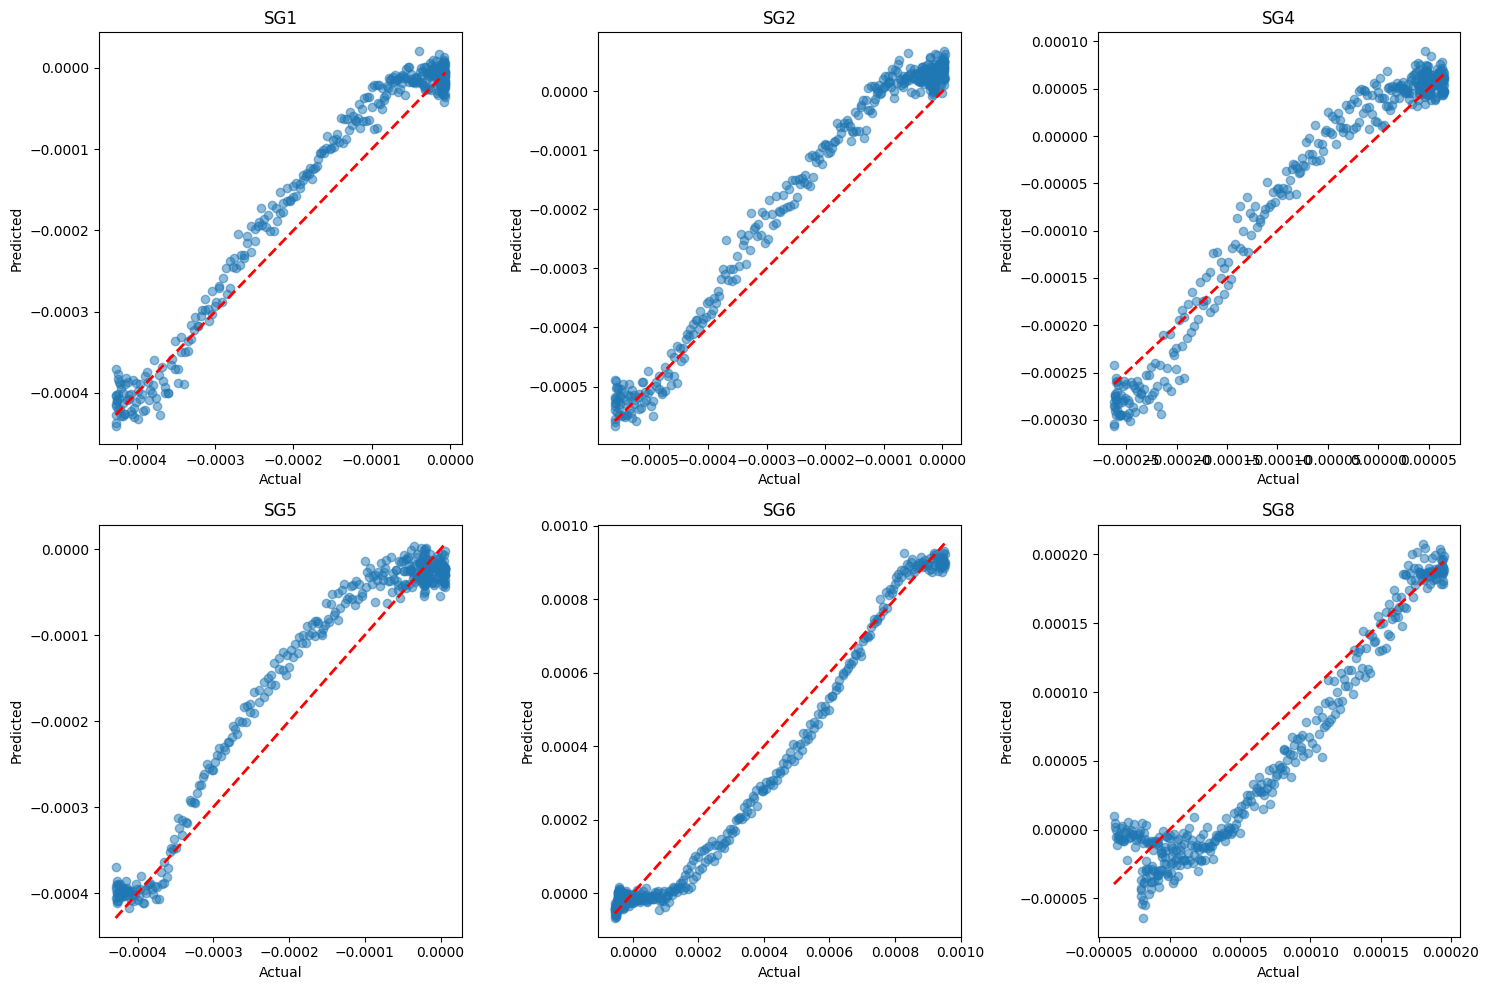

In [ ]:
# Calculate MSE for each strain gauge
mse_per_sg_val = np.mean((predictions_original_val - actuals_original_val)**2, axis=0)

rmse_per_sg_val = np.sqrt(np.mean((predictions_original_val - actuals_original_val)**2, axis=0))

# Create a list of strain gauge names for the MSE values
output_sgs_val = [f'SG{i+1}' for i in np.arange(len(combined_data_val.columns)) if f'SG{i+1}' not in important_sgs]

# Plot MSE for each predicted strain gauge
plt.figure(figsize=(12, 6))
plt.bar(output_sgs_val, rmse_per_sg_val)
plt.xlabel('Strain Gauge')
plt.ylabel('Root Mean Squared Error')
plt.title('Reconstruction Error per Strain Gauge')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize actual vs predicted for a few strain gauges, excluding important ones
output_sgs_val = [sg for sg in combined_data_val.columns if sg not in important_sgs]

num_plots = min(6, len(output_sgs_val))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in np.arange(num_plots):
    sg = output_sgs_val[i]
    sg_index = combined_data_val.columns.get_loc(sg)
    axes[i].scatter(actuals_original_val[:, sg_index], predictions_original_val[:, sg_index], alpha=0.5)
    axes[i].plot([actuals_original_val[:, sg_index].min(), actuals_original_val[:, sg_index].max()],
                 [actuals_original_val[:, sg_index].min(), actuals_original_val[:, sg_index].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(sg)

# Remove any unused subplots
for i in np.arange(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
for sg, mse in zip(output_sgs_val, rmse_per_sg_val):
    print(f"{sg}\t{mse}")

SG1	0.00015414791414514184
SG2	0.00011507941962918267
SG4	3.109169119852595e-05
SG5	5.7136756367981434e-05
SG6	3.3801337849581614e-05
SG8	0.0001298736606258899
SG10	3.453305544098839e-05
SG11	6.673713505733758e-05
SG12	3.168935654684901e-05
SG13	4.0307433664565906e-05
SG15	7.349730731220916e-05
SG16	2.644346750457771e-05
SG17	3.875045877066441e-05
SG18	6.934047996765003e-05
SG19	3.947350705857389e-05
SG21	0.0001211329290526919
SG22	1.2311947102716658e-05
SG23	4.289717981009744e-05
SG24	5.303154466673732e-05
SG25	4.733408786705695e-05


In [ ]:
np.shape(predictions_original_val)

(366, 20)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores_val = []
for i in np.arange(predictions_original_val.shape[1]):
    r2_val = r2_score(actuals_original_val[:, i], predictions_original_val[:, i])
    r2_scores_val.append(r2_val)

# Calculate the median and range of R2 scores
median_r2_val = np.median(r2_scores_val)
range_r2_val = (min(r2_scores_val), max(r2_scores_val))

print(f"Median R2 score: {median_r2_val:.4f}")
print(f"Range of R2 scores: ({range_r2_val[0]:.4f}, {range_r2_val[1]:.4f})")

Median R2 score: 0.9278
Range of R2 scores: (0.6453, 0.9623)


In [ ]:
# Calculate overall RMSE
overall_rmse_val = np.sqrt(mean_squared_error(actuals_original_val, predictions_original_val))

# Create a list of strain gauge names, excluding the important ones
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]


# Print RMSE for each predicted strain gauge
print("\nRMSE for each predicted strain gauge:")
for sg, rmse in zip(output_sgs, rmse_per_sg_val):
    print(f"{sg}: {rmse:.2e}")

print(f"\nOverall RMSE Val: {overall_rmse_val:.2e}")


RMSE for each predicted strain gauge:
SG1: 1.54e-04
SG2: 1.15e-04
SG4: 3.11e-05
SG5: 5.71e-05
SG6: 3.38e-05
SG8: 1.30e-04
SG10: 3.45e-05
SG11: 6.67e-05
SG12: 3.17e-05
SG13: 4.03e-05
SG15: 7.35e-05
SG16: 2.64e-05
SG17: 3.88e-05
SG18: 6.93e-05
SG19: 3.95e-05
SG21: 1.21e-04
SG22: 1.23e-05
SG23: 4.29e-05
SG24: 5.30e-05
SG25: 4.73e-05

Overall RMSE Val: 7.18e-05


In [ ]:
overall_min_val = X_validation.min().min()
overall_max_val = X_validation.max().max()
print(f"\nOverall range across all strain gauges in the test set: {overall_min_val:.6f} to {overall_max_val:.6f}")

range_val = overall_max_val - overall_min_val
rmse_percentage_val = (overall_rmse_val / range_val) * 100
print(f"\nRMSE as percentage of overall validation range: {rmse_percentage_val:.2f}%")


Overall range across all strain gauges in the test set: -0.000433 to 0.001476

RMSE as percentage of overall validation range: 3.76%
